<a href="https://colab.research.google.com/github/Engineer-Gustavo-Softworks/TRATAMENTO-DE-DADOS-INMET-TAREFA-7-E-8/blob/main/METODOS_PARA_CURVA_DE_WEIBULL_BRASILIA_2010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Planilha Brasilia 2010_excel.xlsx to Planilha Brasilia 2010_excel.xlsx


In [25]:
!pip install openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress, weibull_min
from scipy.special import gamma

df = pd.read_excel('Planilha Brasilia 2010_excel.xlsx', engine='openpyxl')

df_copia = df.copy (deep = True)
df_copia [['DATA (YYYY-MM-DD)', 'HORA (UTC)', 'VENTO, VELOCIDADE HORARIA (m/s)']] = df_copia [['DATA (YYYY-MM-DD)', 'HORA (UTC)', 'VENTO, VELOCIDADE HORARIA (m/s)']].replace(-9999,np.nan)

#De acordo com a distribuição do feature, decidi substituir os valores nulos por um método.
df_copia['VENTO, VELOCIDADE HORARIA (m/s)'].fillna(df_copia['VENTO, VELOCIDADE HORARIA (m/s)'].mean(), inplace = True) #média

# Verificando a exitencia de valores duplicados:
df_copia.duplicated().sum()



<ipython-input-25-81f9922f5b69>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copia['VENTO, VELOCIDADE HORARIA (m/s)'].fillna(df_copia['VENTO, VELOCIDADE HORARIA (m/s)'].mean(), inplace = True) #média


np.int64(0)

,DATA (YYYY-MM-DD),HORA (UTC),"VENTO, VELOCIDADE HORARIA (m/s)"
0,2010-01-01,00:00:00,2.44823
1,2010-01-01,01:00:00,2.44823
2,2010-01-01,02:00:00,2.44823
3,2010-01-01,03:00:00,2.44823
4,2010-01-01,04:00:00,2.44823


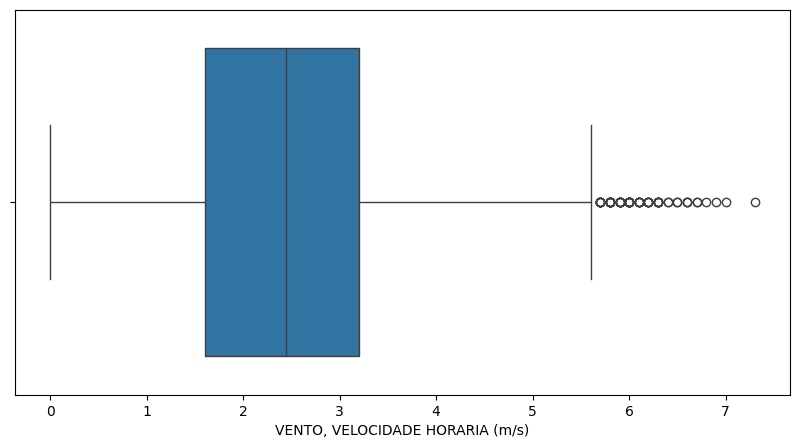

In [20]:
# Analisando a existencia de outleirs em 'VENTO, VELOCIDADE HORARIA (m/s)'
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_copia['VENTO, VELOCIDADE HORARIA (m/s)'])

df_copia.describe()
df_copia.head()

> MÉTODO DA ENERGIA PADRÃO

Parâmetro beta (forma): 2.1681
Parâmetro eta (escala): 2.8206
[Momentos] beta: 1.9736, eta: 2.8015
[Máxima Verossimilhança] beta: 2.2422, eta: 2.8004


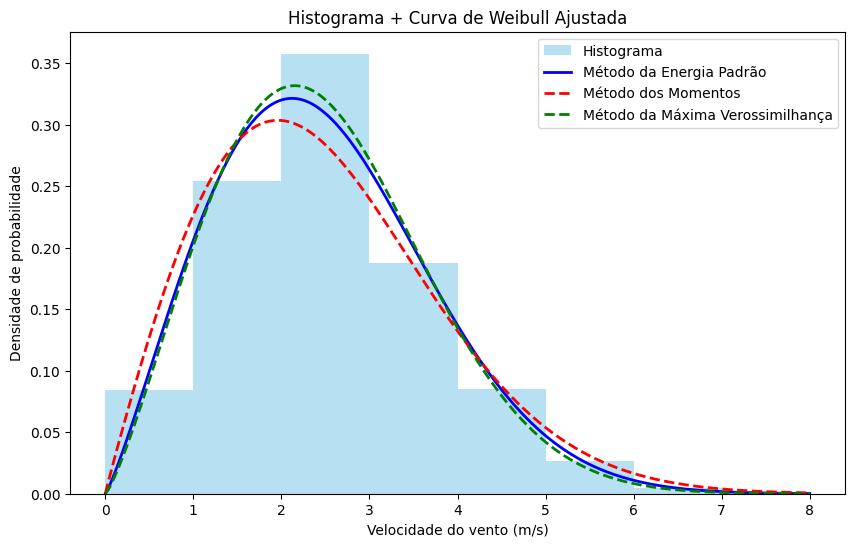

Limites dos bins do histograma: [0. 1. 2. 3. 4. 5. 6. 7. 8.]
Intervalo x para curva Weibull: 0.0 a 8.0


In [34]:
#Carregar os dados

coluna = 'VENTO, VELOCIDADE HORARIA (m/s)'
dados = df_copia[coluna].dropna().sort_values().values
dados = dados[dados > 0]
n = len(dados)

# -------Método da Enegia Padrão-------#

#Estimar a função de distribuição acumulada
i = np.arange(1, n + 1)
F = (i - 0.3) / (n + 0.4)

#Linearização e regressão
ln_t = np.log(dados)
ln_ln = np.log(-np.log(1 - F))

slope, intercept, *_ = linregress(ln_t, ln_ln)
beta = slope
eta = np.exp(-intercept / beta)

print(f"Parâmetro beta (forma): {beta:.4f}")
print(f"Parâmetro eta (escala): {eta:.4f}")

# -------Método dos Momentos-------#

# Momentos amostrais
media = np.mean(dados)
variancia = np.var(dados)

# Estimativa de beta (forma) por aproximação
def estimar_beta_mm(media, variancia):
    for b in np.linspace(0.5, 10, 10000):  #intervalo de 0,5 até 10, com uma dispersão de 10k de pontos ao longo do eixo
        r = gamma(1 + 2/b) - (gamma(1 + 1/b))**2
        if np.isclose(r, variancia / media**2, atol=1e-4):
            return b
    return None

beta_mm = estimar_beta_mm(media, variancia)
eta_mm = media / gamma(1 + 1/beta_mm)

print(f"[Momentos] beta: {beta_mm:.4f}, eta: {eta_mm:.4f}")

# -------Método da Máxima Verossimilhança-------#

# Ajuste da distribuição Weibull aos dados
params = weibull_min.fit(dados, floc=0)
beta_mle, loc_mle, eta_mle = params
print(f"[Máxima Verossimilhança] beta: {beta_mle:.4f}, eta: {eta_mle:.4f}")

# Histograma + Curva de Weibull ajustada
plt.figure(figsize=(10, 6))

# Histograma normalizado
counts, bins, _ = plt.hist(dados, bins=[0,1,2,3,4,5,6,7,8], density=True, alpha=0.6, color='skyblue', label='Histograma')

#------------Curva de Weibull / MEP---------------#
# Eixo x para curva Weibull: mesma faixa do histograma
x = np.linspace(min(bins), max(bins), 300)

# Função densidade Weibull ajustada
weibull_pdf = (beta / eta) * (x / eta)**(beta - 1) * np.exp(-(x / eta)**beta)

# Plot da curva
plt.plot(x, weibull_pdf, 'b', lw=2, label='Método da Energia Padrão')

#------------Curva de Weibull / MM---------------#
pdf_mm = (beta_mm / eta_mm) * (x / eta_mm)**(beta_mm - 1) * np.exp(-(x / eta_mm)**beta_mm)
plt.plot(x, pdf_mm, 'r--', lw=2, label='Método dos Momentos')

#------------Curva de Weibull / MMV---------------#
pdf_mle = (beta_mle / eta_mle) * (x / eta_mle)**(beta_mle - 1) * np.exp(-(x / eta_mle)**beta_mle)
plt.plot(x, pdf_mle, 'g--', lw=2, label='Método da Máxima Verossimilhança')

# Ajustes visuais
plt.title('Histograma + Curva de Weibull Ajustada')
plt.xlabel('Velocidade do vento (m/s)')
plt.ylabel('Densidade de probabilidade')
plt.legend()
plt.grid(False)
plt.show()

print("Limites dos bins do histograma:", bins)
print("Intervalo x para curva Weibull:", x[0], "a", x[-1])

In [14]:
print(dados)
len(dados)
print(np.any(dados <= 0))
print(f"Beta: {beta}")
print(f"Eta: {eta}")

[0.  0.  0.  ... 6.9 7.  7.3]
True
Beta: nan
Eta: nan
